In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imripy.merger_system as ms
from imripy import halo
from imripy import inspiral
from imripy import waveform
from imripy import detector

In [2]:
m1 = 10.*ms.solar_mass_to_pc
m2 = 10.*ms.solar_mass_to_pc
D = 5e8

sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D=D, inclination_angle=np.pi/2., pericenter_angle=np.pi/4.)

In [3]:
# first, compare to Maggiore 2007
a0 = 500.* sp_0.r_isco()
afin = 1.*sp_0.r_isco()

e0 = 0.9

ev_0 =  inspiral.Classic.Evolve(sp_0, a0, e_0=e0, a_fin=afin)

Evolving from  500.0  to  1.0 r_isco with initial eccentricity  0.9  and  Options: 
A termination event occurred.
 -> Evolution took  4.2219e-03  yrs


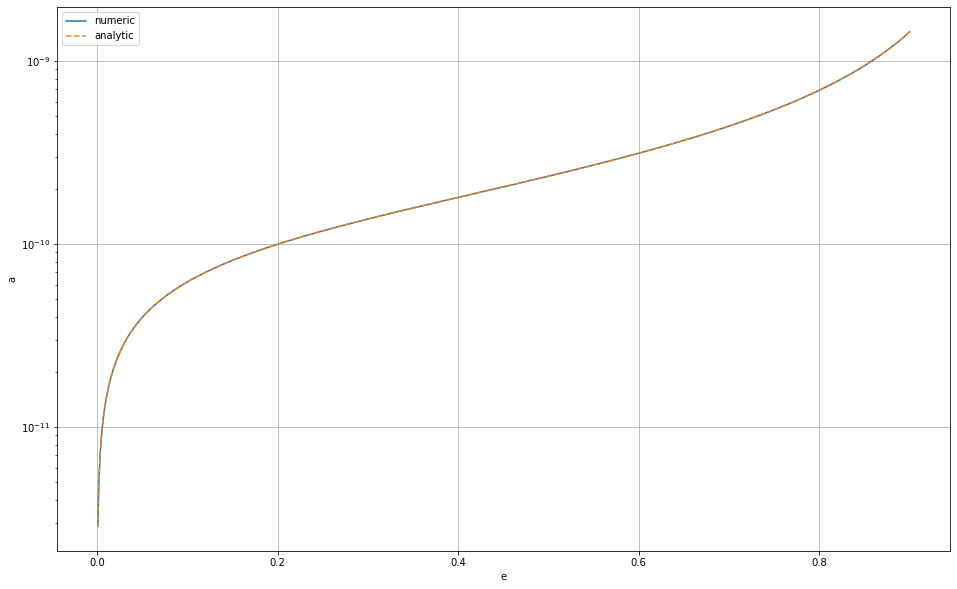

In [4]:
def g(e):
    return e**(12./19.)/(1. - e**2) * (1. + 121./304. * e**2)**(870./2299.)

plt.figure(figsize=(16,10))
plt.plot(ev_0.e, ev_0.a, label='numeric')
plt.plot(ev_0.e, a0 * g(ev_0.e)/g(e0), label='analytic', linestyle='--')
plt.xlabel('e'); plt.ylabel('a')
plt.yscale('log')
plt.grid(); plt.legend()

In [5]:
# Now compare to 1807.07163
a0 = 20.*sp_0.r_isco()
e0 = 0.6
#t, a, e = inspiral.Classic.evolve_elliptic_binary(sp_0, a0, e0, a_fin = 1e-1*sp_0.r_isco(), acc=1e-12)
ev = inspiral.Classic.Evolve(sp_0, a0, e_0=e0, opt=inspiral.Classic.EvolutionOptions(accuracy=1e-12))

Evolving from  20.0  to  1.0 r_isco with initial eccentricity  0.6  and  Options: 
A termination event occurred.
 -> Evolution took  6.5339e-07  yrs


Text(0.5, 0, 't / yr')

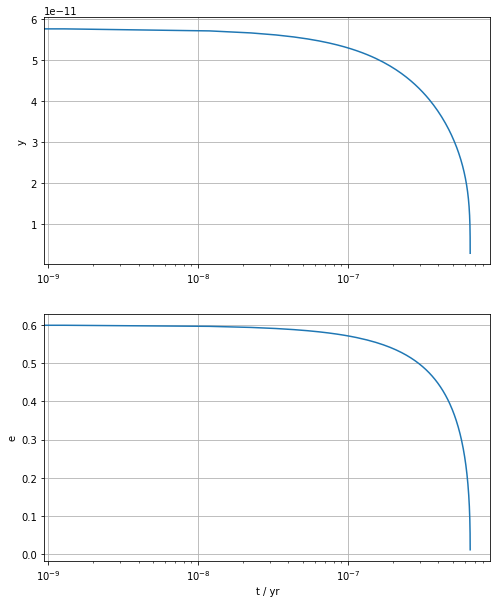

In [6]:
fig, (ax_a, ax_e) = plt.subplots(2, 1, figsize=(8,10))
ax_a.plot(ev.t/ms.year_to_pc, ev.a)

ax_e.plot(ev.t/ms.year_to_pc, ev.e)

ax_a.grid(); ax_a.set_xscale('log'); ax_a.set_ylabel('y')
ax_e.grid(); ax_e.set_xscale('log'); ax_e.set_ylabel('e'); ax_e.set_xlabel('t / yr')

In [7]:
n_comp = 20

wfs = [waveform.h_n(n, sp_0, ev, acc=1e-13) for n in range(1, n_comp+1)]

ValueError: object too deep for desired array

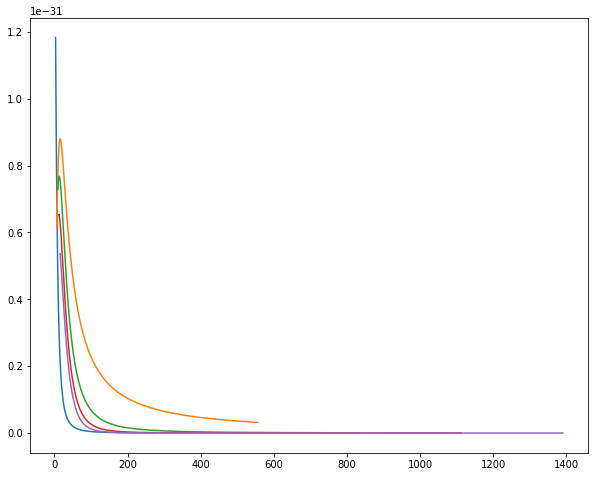

In [8]:
n_disp = 5
plt.figure(figsize=(10, 8))

for i in range( min(len(wfs), n_disp)):
    plt.plot(wfs[i][0]/ms.hz_to_invpc, np.abs(wfs[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")

f_gw = np.geomspace(np.min(wfs[0][0]), np.max(wfs[n_disp][0]), 5000)

h_plus_tot = np.sum([ np.interp(f_gw, wf[0], wf[1], left=0., right=0.) * np.exp(1.j * np.interp(f_gw, wf[0], wf[3], left=0., right=0.)) for wf in wfs ],  axis=0)
h_cross_tot = np.sum([ np.interp(f_gw, wf[0], wf[2], left=0., right=0.) * np.exp(1.j * np.interp(f_gw, wf[0], wf[3], left=0., right=0.)) for wf in wfs ],  axis=0)
plt.plot(f_gw/ms.hz_to_invpc, np.abs(h_plus_tot), label=r"$|h^{SPA}_+|$")

plt.xlim(left=np.min(wfs[0][0])/ms.hz_to_invpc, right=np.max(wfs[n_disp][0])*4e-3/ms.hz_to_invpc)
#plt.xscale('log')
plt.xlabel('f / Hz'); 
plt.grid(); plt.legend();

In [9]:
plt.figure(figsize=(10, 8))
plt.loglog(f_gw/ms.hz_to_invpc, 2.*f_gw*np.abs(h_plus_tot), label=r"$|h^{SPA}_+|$")
#plt.loglog(f_gw, 2.*f_gw*np.abs(h_2_cross), label=r"$|h^{(2)}_x|$")

f = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
plt.plot(f/ms.hz_to_invpc, detector.Lisa().NoiseStrain(f), label='LISA')

plt.ylim(1e-22, 2e-18)
#plt.xlim(detector.Lisa().Bandwith()[0]/ms.hz_to_invpc, detector.Lisa().Bandwith()[1]/ms.hz_to_invpc, )
plt.xlabel('f / Hz'); plt.ylabel('characteristic strain')
plt.grid(); plt.legend();

NameError: name 'h_plus_tot' is not defined

<Figure size 720x576 with 0 Axes>

In [ ]:
t_plot = np.linspace(np.min(ev.t) if ev.t[0] > 0. else ev.t[1]*1e-1, np.max(ev.t), 500)
f_plot = np.linspace(np.min(f_gw), np.max(f_gw)/1000., 500)
t_plot, f_plot = np.meshgrid(t_plot, f_plot)

h_plus_plot = np.zeros(shape=np.shape(t_plot))
h_cross_plot = np.zeros(shape=np.shape(t_plot))
for i in range(len(t_plot[0])):
    for wf in wfs:
        #print(t_plot[i,0])
        f = np.interp(t_plot[0, i], ev.t, wf[0], left=0., right=0.)
        index_f = (np.abs(f_plot[:, i] - f)).argmin()
        #print(f, f_plot[i], index_f)
        h_plus_plot[index_f, i] = np.abs(np.interp(f_plot[index_f, i], wf[0], wf[1]))
        h_cross_plot[index_f, i] = np.abs(np.interp(f_plot[index_f, i], wf[0], wf[2]))
        
h_plus_plot = h_plus_plot/np.max(h_plus_plot)

plt.figure(figsize=(10, 8))
#plt.xscale('log'); plt.yscale('log')
plt.contourf( t_plot/ms.s_to_pc, f_plot/ms.hz_to_invpc, h_plus_plot, cmap=plt.get_cmap("YlOrRd"))

plt.figure(figsize=(10, 8))
#plt.xscale('log'); plt.yscale('log')
plt.contourf( t_plot/ms.s_to_pc, f_plot/ms.hz_to_invpc, h_cross_plot, cmap=plt.get_cmap("YlOrRd"))

plt.show()

In [10]:
# Now compare eccentricity and circular implementation for consistency
from scipy.interpolate import interp1d
D = 1e3
m1 = 1e3 * ms.solar_mass_to_pc
m2 = 1e0 * ms.solar_mass_to_pc
sp_dm = ms.SystemProp(m1, m2, halo.Spike(226.*ms.solar_mass_to_pc, 0.54, 7./3.), D=D, inclination_angle=np.pi/3.)

In [12]:
a0 = 100.*sp_dm.r_isco()
e0 = 0.001
afin= 1.*sp_dm.r_isco()

ev_circ = inspiral.Classic.Evolve(sp_dm, a0, a_fin=afin, opt=inspiral.Classic.EvolutionOptions(accuracy=1e-12))
ev_ecc = inspiral.Classic.Evolve(sp_dm, a0, e_0=e0, a_fin=afin, opt=inspiral.Classic.EvolutionOptions(accuracy=1e-12))

Evolving from  100.0  to  1.0 r_isco with initial eccentricity  0.0  and  Options: 
A termination event occurred.
 -> Evolution took  5.9362e+01  yrs
Evolving from  100.0  to  1.0 r_isco with initial eccentricity  0.001  and  Options: 
A termination event occurred.
 -> Evolution took  5.9362e+01  yrs


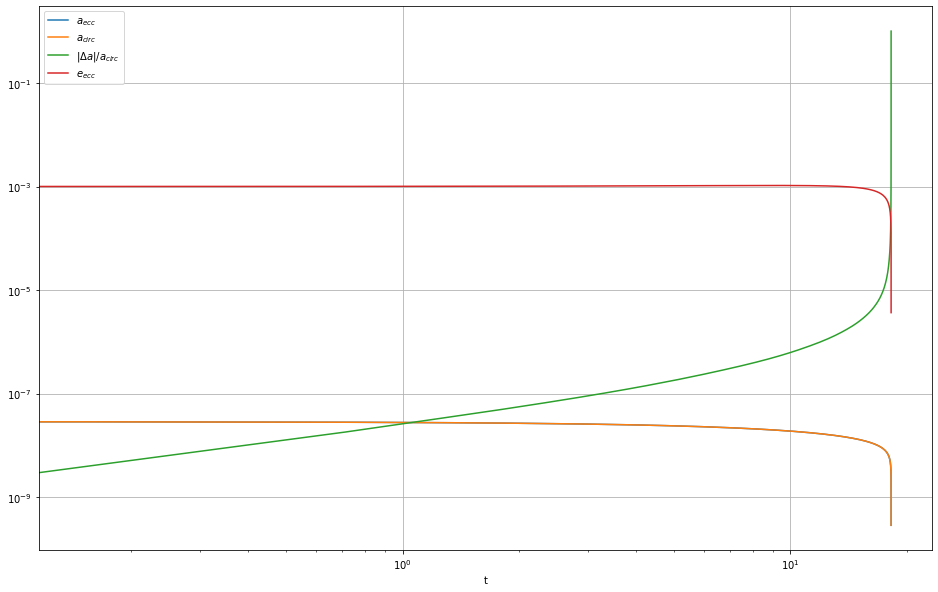

In [13]:
plt.figure(figsize=(16, 10))
plt.loglog(ev_ecc.t, ev_ecc.a, label='$a_{ecc}$')
plt.loglog(ev_circ.t, ev_circ.a, label='$a_{circ}$')
plt.loglog(ev_circ.t, np.abs(ev_circ.a - interp1d(ev_ecc.t, ev_ecc.a, kind='cubic', bounds_error=False, fill_value=(0.,0.))(ev_circ.t))/ev_circ.a
                         , label=r'$|\Delta a|/a_{circ}$')
plt.loglog(ev_ecc.t, ev_ecc.e, label='$e_{ecc}$')
plt.xlabel('t')
plt.grid(); plt.legend()

In [ ]:
print(ev_ecc.a, ev_ecc.e)

In [ ]:
f_gw_circ, h_plus_circ, h_cross_circ, Psi_circ, _, Phi_circ, __ = waveform.h_2(sp_dm, ev_circ, dbg=True)
f_gw_ecc, h_plus_ecc, h_cross_ecc, Psi_ecc, Phi_ecc, _ = waveform.h_n(2, sp_dm, ev_ecc, dbg=True)

In [ ]:
plt.figure(figsize=(16, 10))
plt.loglog(f_gw_circ/ms.hz_to_invpc, h_plus_circ, label="$h_{+}^{circ}$")
plt.loglog(f_gw_ecc/ms.hz_to_invpc,  np.abs(h_plus_ecc), linestyle="--", label="$h_{+}^{ecc}$")
plt.loglog(f_gw_circ/ms.hz_to_invpc, h_cross_circ, label="$h_{x}^{circ}$")
plt.loglog(f_gw_ecc/ms.hz_to_invpc,  np.abs(h_cross_ecc), linestyle="--", label="$h_{x}^{ecc}$")

plt.grid(); plt.legend()

In [ ]:
plt.figure(figsize=(16,10))
plt.loglog(f_gw_ecc/ms.hz_to_invpc, Phi_ecc, label='$\Phi_{ecc}$')
plt.loglog(f_gw_circ/ms.hz_to_invpc, Phi_circ, label='$\Phi_{circ}$')
plt.loglog(f_gw_circ/ms.hz_to_invpc, np.abs(Phi_circ 
                                            - interp1d(f_gw_ecc, Phi_ecc, kind='cubic', fill_value=(0.,0.), bounds_error=False)(f_gw_circ))
                       , label='$|\Delta\Phi|$' )

plt.legend(); plt.grid()